In [1]:
!pip install yfinance
!git clone https://github.com/amazon-science/chronos-forecasting.git
%cd chronos-forecasting
!pip install -e .[training]

Cloning into 'chronos-forecasting'...
remote: Enumerating objects: 449, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 449 (delta 167), reused 86 (delta 86), pack-reused 222 (from 2)
Receiving objects: 100% (449/449), 1008.28 KiB | 3.13 MiB/s, done.
Resolving deltas: 100% (188/188), done.
/content/chronos-forecasting
Obtaining file:///content/chronos-forecasting
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 34.3 MB/s eta 0:00:00
 

In [2]:
import yfinance as yf

tickers = ["AAPL"]
time_series_list = []

for ticker in tickers:
    df = yf.download(ticker, start="2013-01-01", end="2023-01-01")
    time_series_list.append(df["Close"].values.flatten())

[*********************100%***********************]  1 of 1 completed


In [3]:
from pathlib import Path
from typing import List, Union
import numpy as np
from gluonts.dataset.arrow import ArrowWriter

def convert_to_arrow(
    path: Union[str, Path],
    time_series: Union[List[np.ndarray], np.ndarray],
    compression: str = "lz4",
):
    """
    Salva un insieme di serie temporali in formato Arrow nel percorso specificato.
    Ogni serie viene appiattita per essere garantita come array 1D.
    """
    # Impostiamo un tempo di inizio arbitrario
    start = np.datetime64("2000-01-01 00:00", "s")

    # Per ogni serie, assicuriamoci che sia un array 1D
    dataset = [{"start": start, "target": np.array(ts).flatten()} for ts in time_series]

    ArrowWriter(compression=compression).write_to_file(dataset, path=path)
    print(f"File Arrow salvato in: {path}")

# Salva i dati in /content/stock_data.arrow
convert_to_arrow("/content/stock_data.arrow", time_series=time_series_list)

File Arrow salvato in: /content/stock_data.arrow


In [4]:
%%writefile /content/config.yaml
training_data_paths:
  - "/content/stock_data.arrow"
probability:
  - 1.0

model_id: "amazon/chronos-t5-tiny"
random_init: false

max_steps: 1000
learning_rate: 0.001

shuffle_buffer_length: 1000
torch_compile: false

Writing /content/config.yaml


In [5]:
!CUDA_VISIBLE_DEVICES=0 python scripts/training/train.py --config /content/config.yaml

2025-02-02 10:21:15.833331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738491676.074135    2916 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738491676.135652    2916 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 10:21:16.613511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-02 10:21:22,953 - /content/chronos-forecasting/scripts/training/train.py - INFO - TF32 format is only availab

In [10]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-1580r4dj
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-1580r4dj
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 39515ff0fcdae55bbbf546d90193dbe54b201556
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Variance (Zero-Shot): [ 3.236483   6.1002364 11.207233  16.225601  16.861973  21.373495
 27.044163  25.025888  28.128292  23.95542  ]
Variance (Fine-Tuned): [ 2.3159938  4.6274414  4.934274   7.6798296  9.191258  12.261814
 17.025633  19.771198  22.11673   44.17433  ]


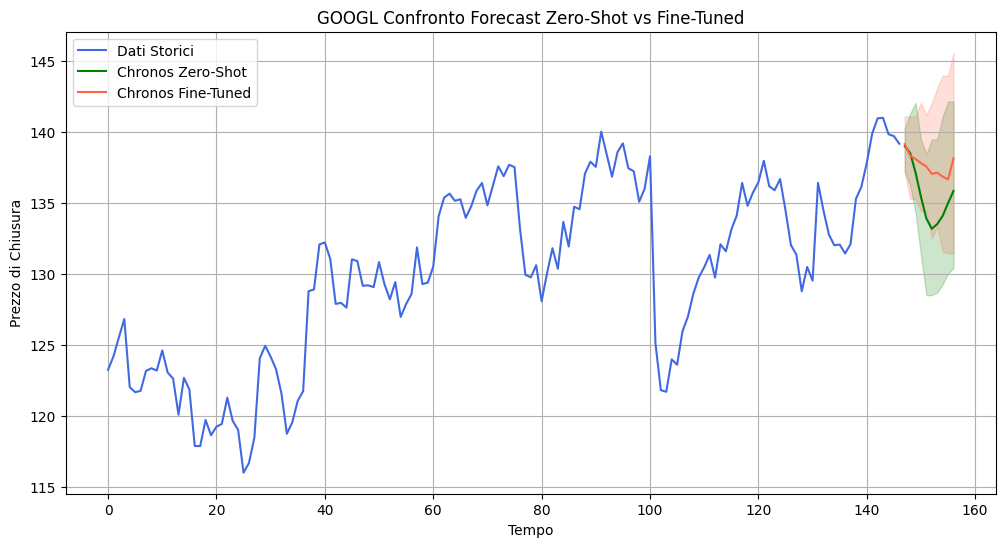

In [12]:
import pandas as pd
import yfinance as yf
import torch
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
from chronos import ChronosPipeline

# SEED per riproducibilità
seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# MODELLO CHRONOS (Zero-Shot)
zero_shot_pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

# MODELLO FINE-TUNED
fine_tuned_pipeline = ChronosPipeline.from_pretrained("output/run-0/checkpoint-final/")

# DATI FINANZIARI
symbol = "GOOGL"
data = yf.download(symbol, start="2023-06-01", end="2023-12-31", progress=False)

# Estrarre i prezzi di chiusura
df = data.reset_index()
close_prices = df["Close"].values.reshape(-1)

# FORECASTING con entrambi i modelli
prediction_length = 10  # Orizzonte della previsione

# Zero-Shot
forecast_zero_shot = zero_shot_pipeline.predict(
    context=torch.tensor(close_prices), prediction_length=prediction_length
)

# Fine-Tuned
forecast_fine_tuned = fine_tuned_pipeline.predict(
    context=torch.tensor(close_prices), prediction_length=prediction_length
)

# Analisi Statistica delle Previsioni
def get_forecast_stats(forecast_tensor):
    """ Calcola media, intervallo di confidenza e varianza per il forecast """
    low, median, high = np.quantile(forecast_tensor.numpy(), [0.1, 0.5, 0.9], axis=0)
    mean_forecast = np.mean(forecast_tensor.numpy(), axis=0)
    variance_forecast = np.var(forecast_tensor.numpy(), axis=0)
    return low, median, high, mean_forecast, variance_forecast

# Statistiche per entrambi i modelli
low_zero, median_zero, high_zero, mean_zero, var_zero = get_forecast_stats(forecast_zero_shot[0])
low_fine, median_fine, high_fine, mean_fine, var_fine = get_forecast_stats(forecast_fine_tuned[0])

print(f'Variance (Zero-Shot): {var_zero}')
print(f'Variance (Fine-Tuned): {var_fine}')

# Grafico Confronto Previsioni
forecast_index = range(len(close_prices), len(close_prices) + prediction_length)

plt.figure(figsize=(12, 6))
plt.plot(close_prices, color="royalblue", label="Dati Storici")
plt.plot(forecast_index, mean_zero, color="green", label="Chronos Zero-Shot")
plt.fill_between(forecast_index, low_zero, high_zero, color="green", alpha=0.2)

plt.plot(forecast_index, mean_fine, color="tomato", label="Chronos Fine-Tuned")
plt.fill_between(forecast_index, low_fine, high_fine, color="tomato", alpha=0.2)

plt.title(f"{symbol} Confronto Forecast Zero-Shot vs Fine-Tuned")
plt.xlabel("Tempo")
plt.ylabel("Prezzo di Chiusura")
plt.legend()
plt.grid()
plt.show()

In [16]:
from scipy.stats import gmean
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Zero-Shot
forecast_zero_shot = zero_shot_pipeline.predict(
    context=torch.tensor(close_prices), prediction_length=prediction_length
)[0].numpy().mean(axis=0)  # Media della distribuzione predetta

# Fine-Tuned
forecast_fine_tuned = fine_tuned_pipeline.predict(
    context=torch.tensor(close_prices), prediction_length=prediction_length
)[0].numpy().mean(axis=0)  # Media della distribuzione predetta

# DATI REALI per il confronto
actual_values = close_prices[-prediction_length:]

# FUNZIONI DI VALUTAZIONE
def mase(y_true, y_pred, y_train):
    """
    Calcola il Mean Absolute Scaled Error (MASE)
    y_true: valori reali
    y_pred: previsioni
    y_train: serie storica per calcolare il naive benchmark
    """
    naive_forecast = np.abs(np.diff(y_train)).mean()  # Modello Naive: differenze medie tra valori successivi
    return np.mean(np.abs(y_true - y_pred)) / naive_forecast

def compute_metrics(y_true, y_pred, y_train):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mase_score = mase(y_true, y_pred, y_train)
    return {"MSE": mse, "RMSE": rmse, "MAPE": mape, "MASE": mase_score}

# Risultati numerici per entrambi i modelli
metrics_zero_shot = compute_metrics(actual_values, forecast_zero_shot, close_prices[:-prediction_length])
metrics_fine_tuned = compute_metrics(actual_values, forecast_fine_tuned, close_prices[:-prediction_length])

# Creazione DataFrame per confronto
results_df = pd.DataFrame(
    [metrics_zero_shot, metrics_fine_tuned],
    index=["Chronos Zero-Shot", "Chronos Fine-Tuned"]
)

# CALCOLO SCORE RELATIVO
def agg_relative_score(model_df: pd.DataFrame, baseline_df: pd.DataFrame):
    relative_score = model_df / baseline_df  # Rapporto tra modello e baseline
    return relative_score.agg(gmean)  # Media geometrica dei miglioramenti

# Confronto Fine-Tuned vs Zero-Shot
relative_scores = agg_relative_score(results_df.loc["Chronos Fine-Tuned"], results_df.loc["Chronos Zero-Shot"])

# OUTPUT RISULTATI
print("RISULTATI METRICHE:")
print(results_df)
print("-------------------------------------------------")
print("SCALING PERFORMANCE (Fine-Tuned vs Zero-Shot):")
print(relative_scores)

RISULTATI METRICHE:
                          MSE      RMSE      MAPE      MASE
Chronos Zero-Shot   21.061854  4.589320  3.029029  2.645984
Chronos Fine-Tuned  10.862715  3.295863  2.003206  1.737450
-------------------------------------------------
SCALING PERFORMANCE (Fine-Tuned vs Zero-Shot):
MSE     0.515753
RMSE    0.718159
MAPE    0.661336
MASE    0.656637
dtype: float64


<ipython-input-16-02dc5a1c318a>:48: FutureWarning: using <function gmean at 0x78ec7497cea0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  return relative_score.agg(gmean)  # Media geometrica dei miglioramenti
